In [52]:
# Imports
import numpy
import matplotlib.pyplot as plt
import scipy.io
import math

# 6x6 Grid That Is Displayed To The User
MATRIX = numpy.array([['A', 'B', 'C', 'D', 'E', 'F'], \
                      ['G', 'H', 'I', 'J', 'K', 'L'], \
                      ['M', 'N', 'O', 'P', 'Q', 'R'], \
                      ['S', 'T', 'U', 'V', 'W', 'X'], \
                      ['Y', 'Z', '1', '2', '3', '4'], \
                      ['5', '6', '7', '8', '9', '_']])

# Function To Get Average Of All Signals (And Channels) Within 1 Run
def get_runs_average(
        signals,
        stimulus_code,
        matrix,
        repeatitions = 15,
        start_window = 0,
        end_window = 128
    ):
    
    intensifications = matrix.shape[0] + matrix.shape[1]
    window = end_window - start_window
    responses = numpy.zeros((signals.shape[0], intensifications, window, signals.shape[2]))
    
    for epoch in range(signals.shape[0]):
        
        # Sum of All Repeatitions -> Division of Sum -> Average
        intensification_counter = numpy.zeros((intensifications))
        for n in range(1, signals.shape[1]):
            if stimulus_code[epoch, n] != stimulus_code[epoch, n - 1] and stimulus_code[epoch, n - 1] != 0:
                intensification_counter[int(stimulus_code[epoch, n - 1]) - 1] += 1
                responses[epoch, int(stimulus_code[epoch, n - 1]) - 1] += signals[epoch, n + start_window - 12 : n + end_window - 12]
        for intensification in range(intensifications):
            responses[epoch, intensification] /= intensification_counter[intensification]
        
        moving_average_filter = 1
        # Calculation of Moving Average
        for intensification in range(responses.shape[1]):
            for sample in range(math.ceil(responses.shape[2] / moving_average_filter)):
                if ((sample * moving_average_filter) + moving_average_filter) < responses.shape[2]:
                    responses[epoch, intensification, (sample * moving_average_filter) : ((sample * moving_average_filter) + moving_average_filter), :] = \
                        numpy.mean(responses[epoch, intensification, (sample * moving_average_filter) : ((sample * moving_average_filter) + moving_average_filter), :], axis=0)
                else:
                    responses[epoch, intensification, (sample * moving_average_filter) : , :] = \
                        numpy.mean(responses[epoch, intensification, (sample * moving_average_filter) : , :], axis=0)
    
    return responses

# Function To Get Average Of All Signals (And Channels) Within 1 Session
def get_sessions_average(
        average_signals,
        target_char,
        matrix,
        repeatitions = 15,
        start_window = 0,
        end_window = 128
    ):
    
    window = end_window - start_window
    intensifications = matrix.shape[0] + matrix.shape[1]
    sum_responses_Success = numpy.zeros((window, average_signals.shape[3]))
    sum_responses_Fail = numpy.zeros((window, average_signals.shape[3]))
    
    # Looping Through Characters (85 Character)
    for epoch in range(average_signals.shape[0]):
        
        # Getting Index Of Chosen Character
        indices = numpy.where(matrix == target_char[epoch])
        chosen_column = indices[1][0]
        chosen_row = indices[0][0] + matrix.shape[1]
        
        for row_column in range(intensifications):
            if row_column == chosen_row or row_column == chosen_column:
                sum_responses_Success += average_signals[epoch, row_column]
            else:
                sum_responses_Fail += average_signals[epoch, row_column]

    average_responses_Success = sum_responses_Success / (average_signals.shape[0] * 2)
    average_responses_Fail = sum_responses_Fail / (average_signals.shape[0] * (intensifications - 2))
    
    return average_responses_Success, average_responses_Fail

M Train
Subject M Signal Train: (1, 4778, 14)
Subject M TargetChar Train: 1
Subject M StimulusCode Train: (1, 4778)

Subject M Average Signal Train: (1, 12, 82, 14)


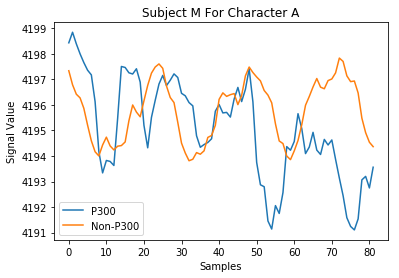

In [149]:
# Declarations
Subject_M_TargetChar_Train = 'E'

Subject_M_Signal_Train = numpy.loadtxt('../Grapgical User Interface/signal_' + Subject_M_TargetChar_Train[0] + '.txt').reshape(1, -1, 14)[:,:,:]
Subject_M_StimulusCode_Train = numpy.loadtxt('../Grapgical User Interface/stimulus_code_' + Subject_M_TargetChar_Train[0] + '.txt').reshape(1, -1)[:,:]

for char in Subject_M_TargetChar_Train[1 : ]:
    Subject_M_Signal_Train_CHAR = numpy.loadtxt('../Grapgical User Interface/signal_' + char + '.txt').reshape(1, -1, 14)[:,:,:]
    Subject_M_StimulusCode_Train_CHAR = numpy.loadtxt('../Grapgical User Interface/stimulus_code_' + char + '.txt').reshape(1, -1)[:,:]
    
    Subject_M_Signal_Train = numpy.append(Subject_M_Signal_Train, Subject_M_Signal_Train_CHAR, axis = 0)
    Subject_M_StimulusCode_Train = numpy.append(Subject_M_StimulusCode_Train, Subject_M_StimulusCode_Train_CHAR, axis = 0)

print('M Train')
print('Subject M Signal Train:', Subject_M_Signal_Train.shape)
print('Subject M TargetChar Train:', len(Subject_M_TargetChar_Train))
print('Subject M StimulusCode Train:', Subject_M_StimulusCode_Train.shape)

Subject_M_Average_Signal_Train = get_runs_average(
    Subject_M_Signal_Train,
    Subject_M_StimulusCode_Train,
    MATRIX,
    start_window = 0,
    end_window = 82
)
print('\nSubject M Average Signal Train:', Subject_M_Average_Signal_Train.shape)

M_Success, M_Fail = get_sessions_average(
    Subject_M_Average_Signal_Train,
    Subject_M_TargetChar_Train,
    MATRIX,
    start_window = 0,
    end_window = 82
)

axA = plt.subplot(1, 1, 1)
axA.plot(M_Success[:, 0])
axA.plot(M_Fail[:, 0])
axA.set_title('Subject M For Character A')
axA.set_xlabel('Samples')
axA.set_ylabel('Signal Value')
axA.legend(('P300', 'Non-P300'))